In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
oil_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
sample_submission_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
holiday_events_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
train_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
transactions_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [4]:
"""
Daily oil price. Includes values during both the train and test data timeframes.
(Ecuador is an oil-dependent country and it's economical health is highly vulnerable
to shocks in oil prices.)

Take into account that the stock market does not work on weekends. Therefore we will
have jumps in days that do not correspond to datapoints directly, i.e., the price
list with 1000 prices does not correspond to 1000 prices in row days, it is
the price of the first 1000 workdays (discarding holidays, festivities and weekends)
"""
print("This pandas is oil_df\n")
print("Size of the pandas is: ", oil_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", oil_df.isnull().sum())
print(" ")
#It can be observed the only missing data is in oil_df
print("Information is: \n", oil_df.describe())
print(" ")


#Let´s add two columns for our interest:
oil_df["Month"]=oil_df["date"].apply(lambda x: int(x.split("-")[1]))
oil_df["Year"]=oil_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
oil_df.head()

This pandas is oil_df

Size of the pandas is:  (1218, 2)
 
The number of null elements (NaN) is: 
 date           0
dcoilwtico    43
dtype: int64
 
Information is: 
         dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
 


,date,dcoilwtico,Month,Year
0,2013-01-01,NaN,1,2013
1,2013-01-02,93.14,1,2013
2,2013-01-03,92.97,1,2013
3,2013-01-04,93.12,1,2013
4,2013-01-07,93.20,1,2013


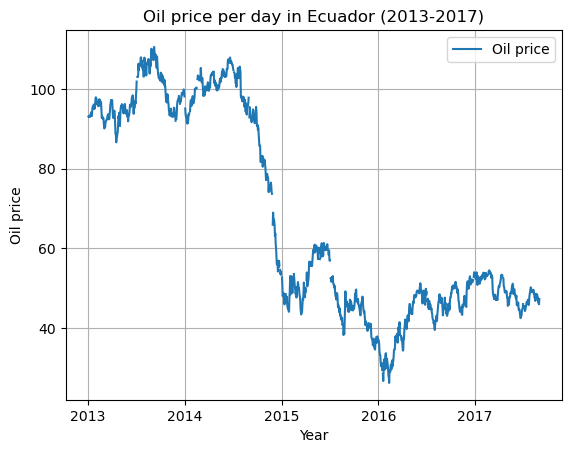

In [5]:
"""
Observe empty areas, that is the NaN part, we will make a tendency to make those missing data be filled
We will fill this data too with an RNN, training with the first not NaN and then filling the NaN part.
We will divide it in sections
"""

# xtick_positions=[0, 1*365, 2*365, 3*365, 4*365] #We can´t do this because of what we explained about weekdays and holidays before
xtick_positions=[oil_df.loc[oil_df['Year'] == 2013].index[0], oil_df.loc[oil_df['Year'] == 2014].index[0],
                 oil_df.loc[oil_df['Year'] == 2015].index[0], oil_df.loc[oil_df['Year'] == 2016].index[0],
                 oil_df.loc[oil_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.plot(oil_df["date"], oil_df["dcoilwtico"], label="Oil price")
plt.title("Oil price per day in Ecuador (2013-2017)")
plt.xlabel("Year")
plt.ylabel("Oil price")
plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

Text(0.5, 1.0, 'dcoilwtico Frequency per year')

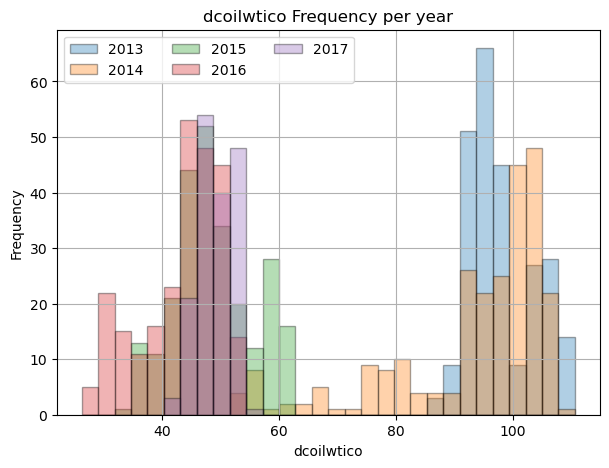

In [6]:
"""
Checking both plots, we can corroborate that the years that had the highest oil price were 2013 and 2014.
After year 2014 the price plumbed. Something happened.
"""


dcoilwtico_hist=pd.concat([oil_df[oil_df.Year==2013]['dcoilwtico'],oil_df[oil_df.Year==2014]['dcoilwtico'], oil_df[oil_df.Year==2015]['dcoilwtico'], oil_df[oil_df.Year==2016]['dcoilwtico'], oil_df[oil_df.Year==2017]['dcoilwtico']],axis=1)
dcoilwtico_hist.columns=["2013", "2014", "2015", "2016", "2017"]
dcoilwtico_hist.plot(kind="hist", bins=30, edgecolor="black", figsize=(7,5), alpha=0.35)
plt.xlabel("dcoilwtico")
plt.grid("True")
plt.legend(ncol=3)
plt.title("dcoilwtico Frequency per year")

In [7]:
print("This pandas is holiday_evets_df\n")
print("Size of the pandas is: ", holiday_events_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", holiday_events_df.isnull().sum())
print(" ")
print("Information is: \n", holiday_events_df.describe())
print(" ")


#Let´s add two columns for our interest:
holiday_events_df["Month"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[1]))
holiday_events_df["Year"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
holiday_events_df.head()

This pandas is holiday_evets_df

Size of the pandas is:  (350, 6)
 
The number of null elements (NaN) is: 
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
 
Information is: 
               date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338
 


,date,type,locale,locale_name,description,transferred,Month,Year
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,3,2012
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012


In [8]:
# holiday_events_df["description"].unique() # Here we found that there was a worldwide futbol competition and an earthquake
# Let´s check the dates

longest_events_dates_df=pd.concat([holiday_events_df[holiday_events_df.description.str.contains("Mundial")], holiday_events_df[holiday_events_df.description.str.contains("Terremoto")]])
#These dates can be of interest. Let´s observe when these two events started:
print("Mundial in Brazil started: {} and Earthquake stated: {}".format(holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Mundial")].index[0]]["date"],
                                                                      holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Terremoto")].index[0]]["date"]))

Mundial in Brazil started: 2014-06-12 and Earthquake stated: 2016-04-16


In 2014 they were almost at their top in oil price and in 2016 they were almost at the bottom. The earthquake undermined the oil price at that moment with the last dump.

In [9]:
"""
stores.csv:

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.
"""
print("This pandas is stores_df\n")
print("Size of the pandas is: ", stores_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", stores_df.isnull().sum())
print(" ")
print("Information is: \n", stores_df.describe())
print(" ")

stores_df.head()

This pandas is stores_df

Size of the pandas is:  (54, 5)
 
The number of null elements (NaN) is: 
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
 
Information is: 
        store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
 


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
"""
train.csv:

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr: identifies the store at which the products are sold.
family: identifies the type of product sold.
sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.
"""

print("This pandas is train_df\n")
print("Size of the pandas is: ", train_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", train_df.isnull().sum())
print(" ")
print("Information is: \n", train_df.describe())
print(" ")

#Let´s add two columns for our interest:
train_df["Month"]=train_df["date"].apply(lambda x: int(x.split("-")[1]))
train_df["Year"]=train_df["date"].apply(lambda x: int(x.split("-")[0]))
train_df["Day"]=train_df["date"].apply(lambda x: int(x.split("-")[2]))
                                                         
train_df.head()

This pandas is train_df

Size of the pandas is:  (3000888, 6)
 
The number of null elements (NaN) is: 
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
 
Information is: 
                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
 


,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,1,2013,1


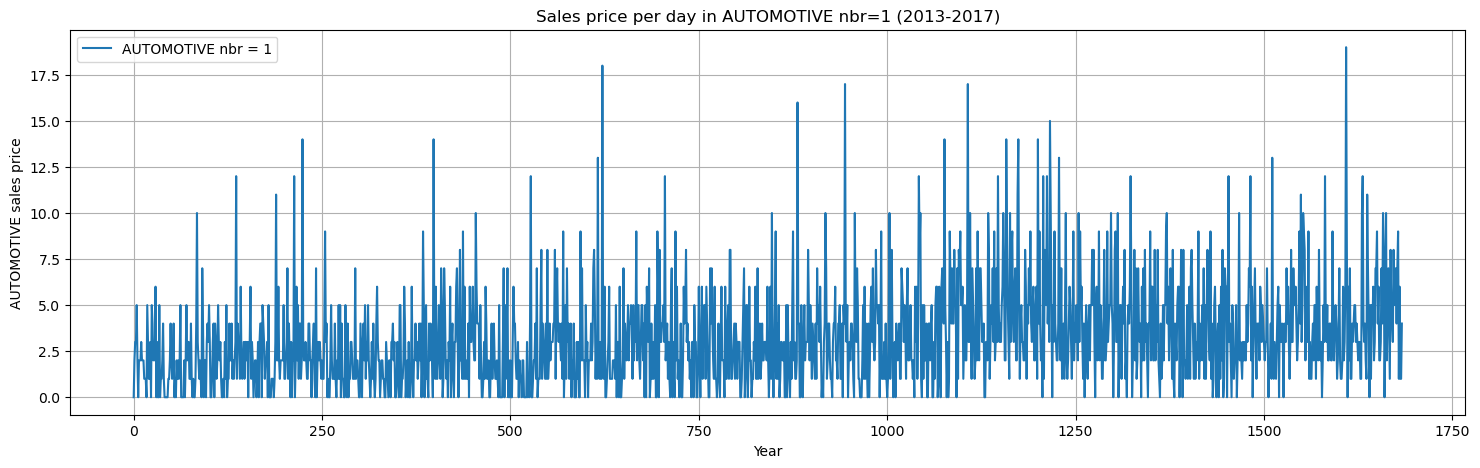

In [11]:
xtick_positions=[train_df.loc[train_df['Year'] == 2013].index[0], train_df.loc[train_df['Year'] == 2014].index[0],
                 train_df.loc[train_df['Year'] == 2015].index[0], train_df.loc[train_df['Year'] == 2016].index[0],
                 train_df.loc[train_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.figure(figsize=(18,5))
plt.plot(np.arange(len(train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales)),
         train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales, label="AUTOMOTIVE nbr = 1")
plt.title("Sales price per day in AUTOMOTIVE nbr=1 (2013-2017)")
plt.xlabel("Year")
plt.ylabel("AUTOMOTIVE sales price")
#plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

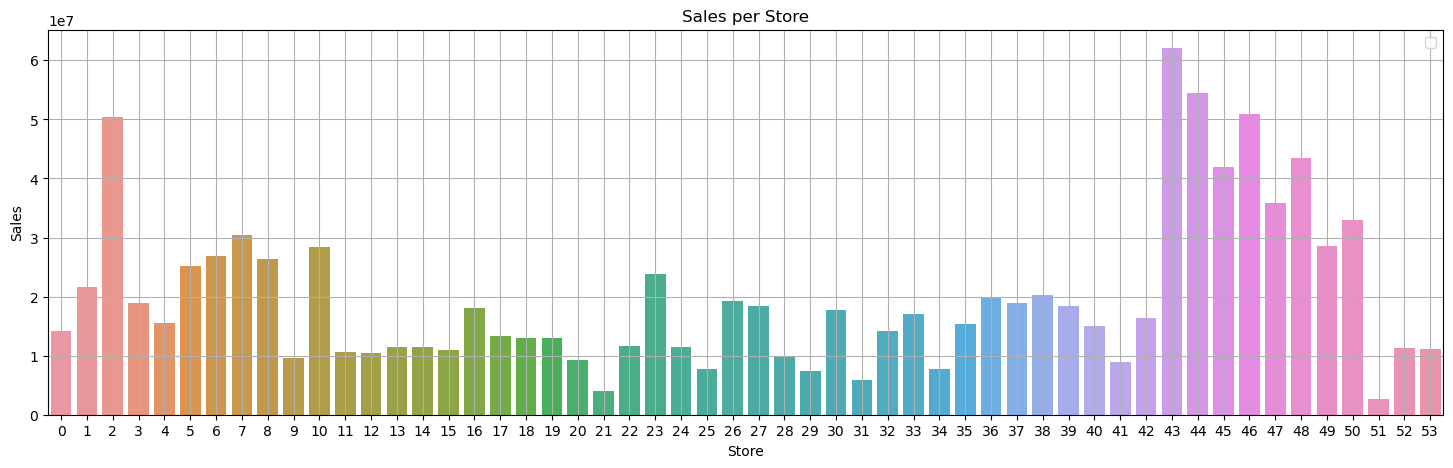

In [12]:
nbr_sales=train_df.groupby(["store_nbr"], as_index=False).agg({"sales":"sum"})

plt.figure(figsize=(18,5))
sns.barplot(x=nbr_sales.index, y="sales", data=nbr_sales)
plt.title("Sales per Store")
plt.xlabel("Store")
plt.ylabel("Sales")
#plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

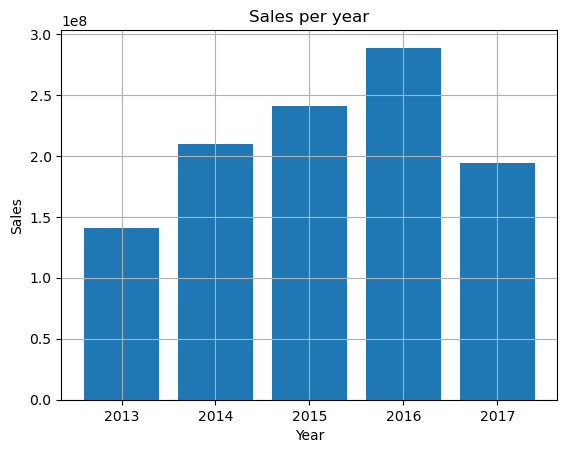

In [13]:
new_year_table=train_df.groupby(["Year"], as_index=False).agg({"sales":"sum"})
#as_index=False to set the Year as a column and have another index instead of Year
plt.bar(new_year_table.Year, new_year_table.sales)
plt.title("Sales per year")
plt.ylabel("Sales")
plt.xlabel("Year")
plt.grid("True")

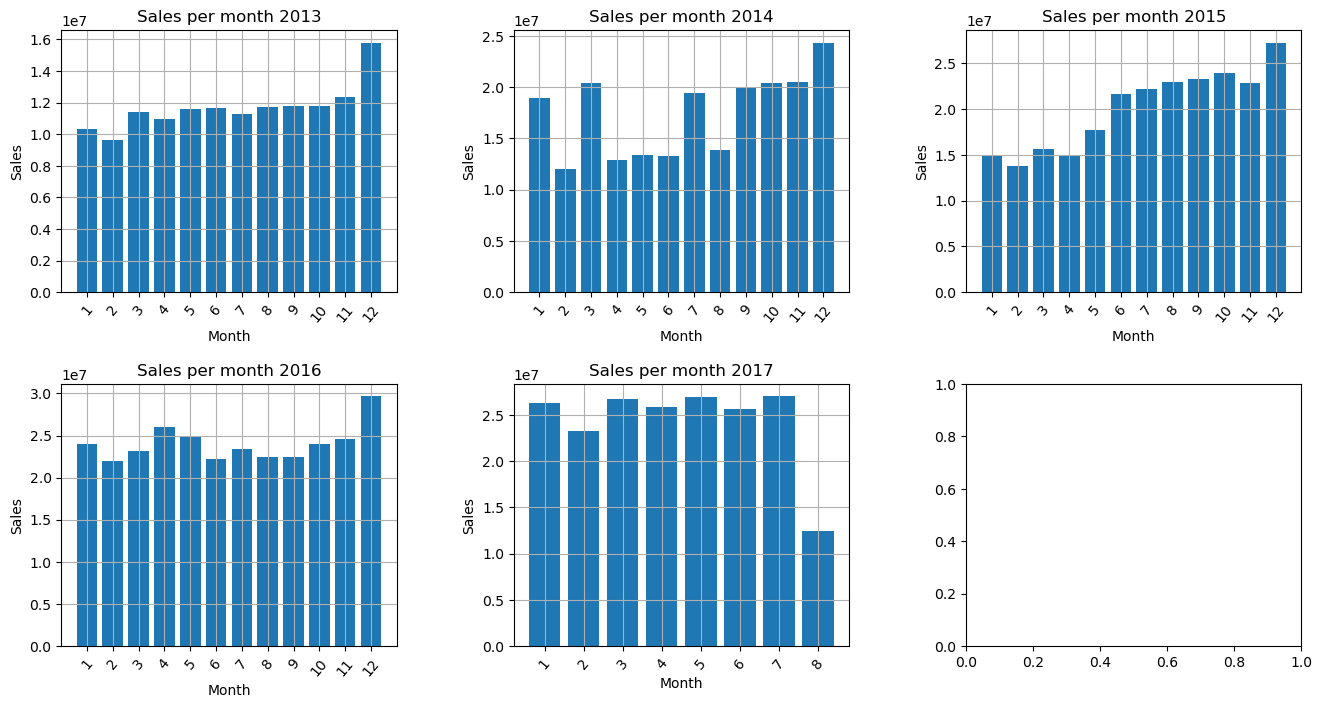

In [14]:
nrows=2
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
plt.subplots_adjust(wspace=0.35, hspace=0.35)
i=0 #i=row
j=0 #j=column
for year in train_df["Year"].unique():
    
    selected_subtable=train_df[train_df["Year"]==year]
    selected_subtable=selected_subtable.groupby(["Month"], as_index=False).agg({"sales":"sum"})
    
    axs[i,j].bar(selected_subtable.Month, selected_subtable.sales)
    axs[i,j].set_xticks(selected_subtable.Month)
    axs[i,j].set_xticklabels(selected_subtable.Month, rotation=50)
    axs[i,j].set_title("Sales per month {}".format(str(year)))
    axs[i,j].set_xlabel("Month")
    axs[i,j].set_ylabel("Sales")
    axs[i,j].grid(True)
    j=j+1
    if j==ncols:
        i=i+1
        j=0

Let´s analyze the best (apparently) year 2015

In [15]:
store_train_df=train_df.merge(stores_df, how="inner", on="store_nbr")
"""
It follows a very similar style as with SQL. It performs an inner join between two DataFrames
train_df and stores_df based on the common column "store_nbr".

The resulting DataFrame "store_train_df" will contain the combined data from both DataFrames,
where the rows with matching "store_nbr" values are merged together.
"""

#Let´s check the year 2015
store_train_2015_df=store_train_df[store_train_df.Year==2015]
store_train_2015_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Month',
       'Year', 'Day', 'city', 'state', 'type', 'cluster'],
      dtype='object')

<Figure size 640x480 with 0 Axes>

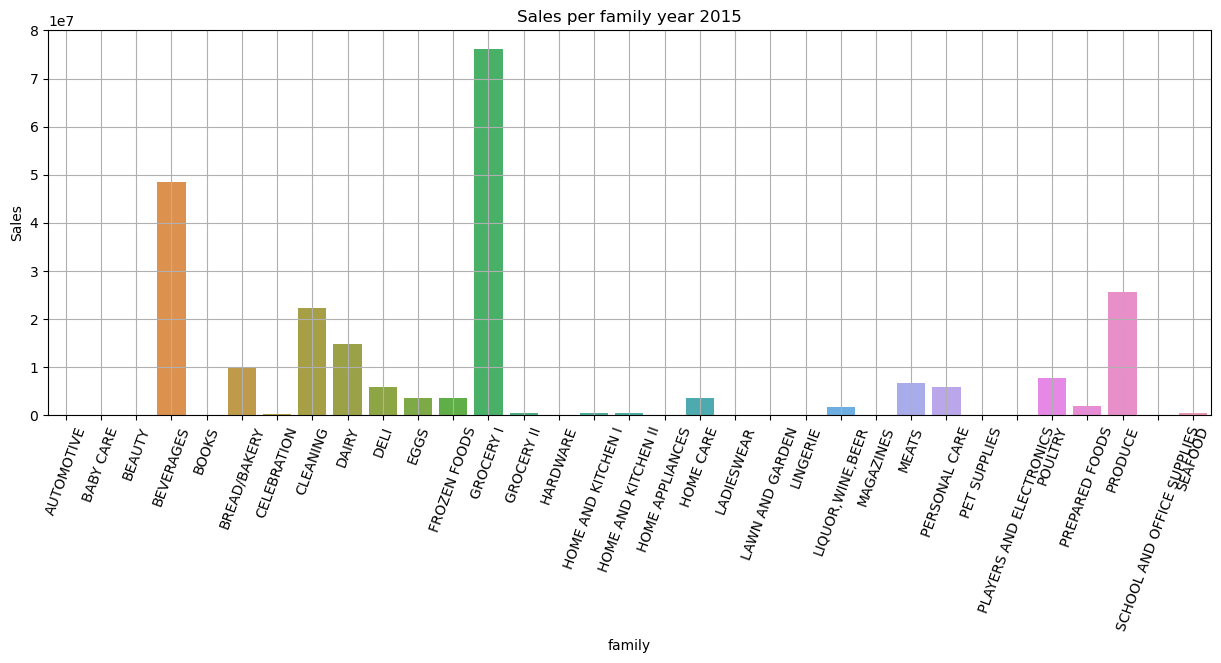

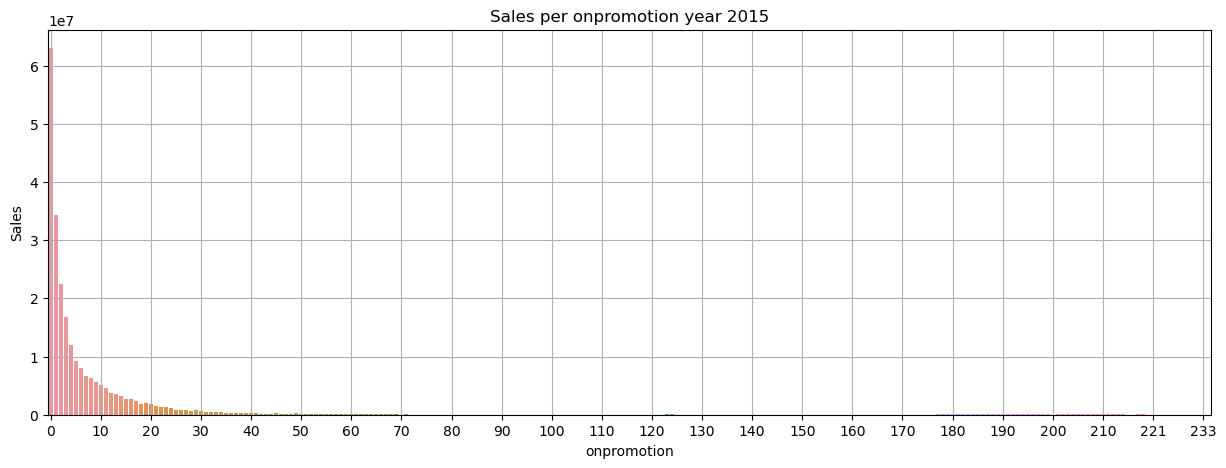

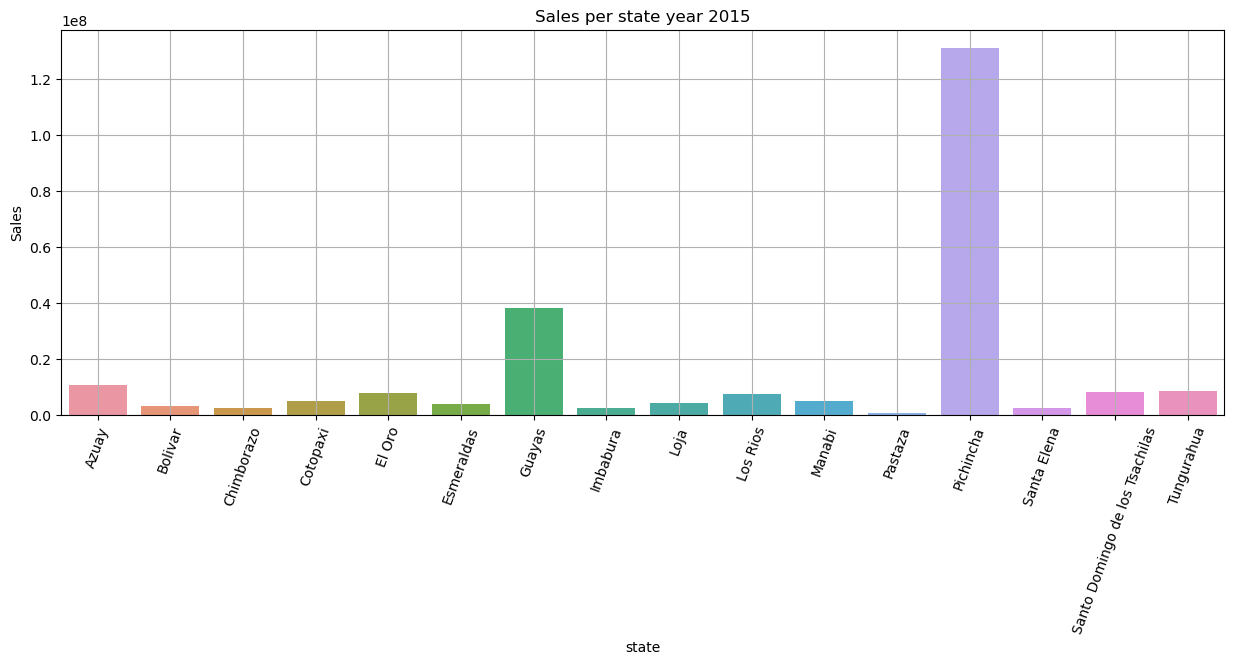

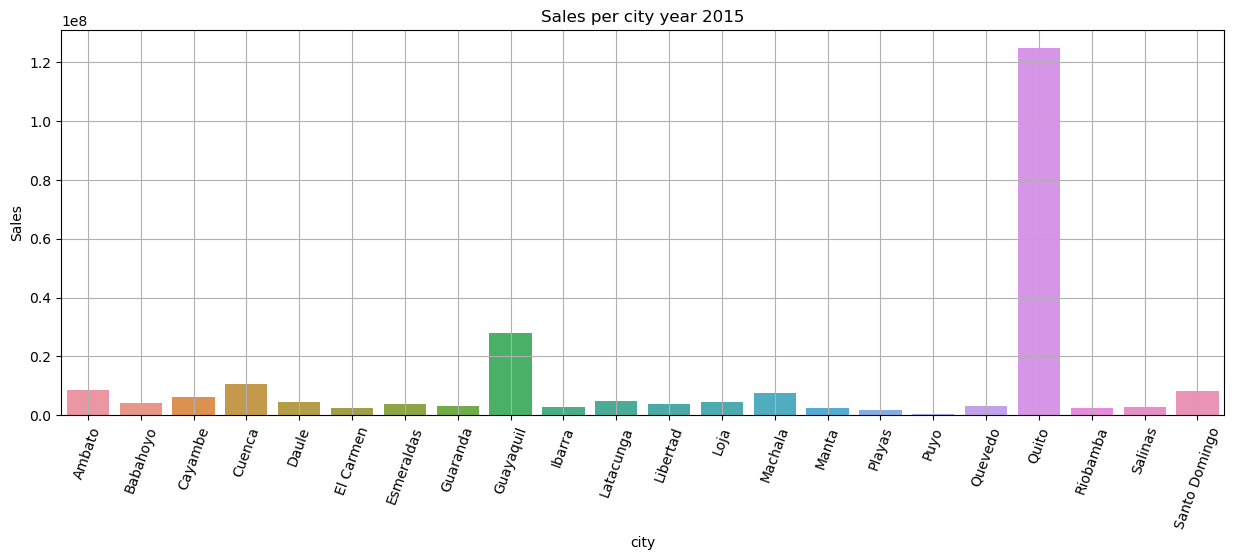

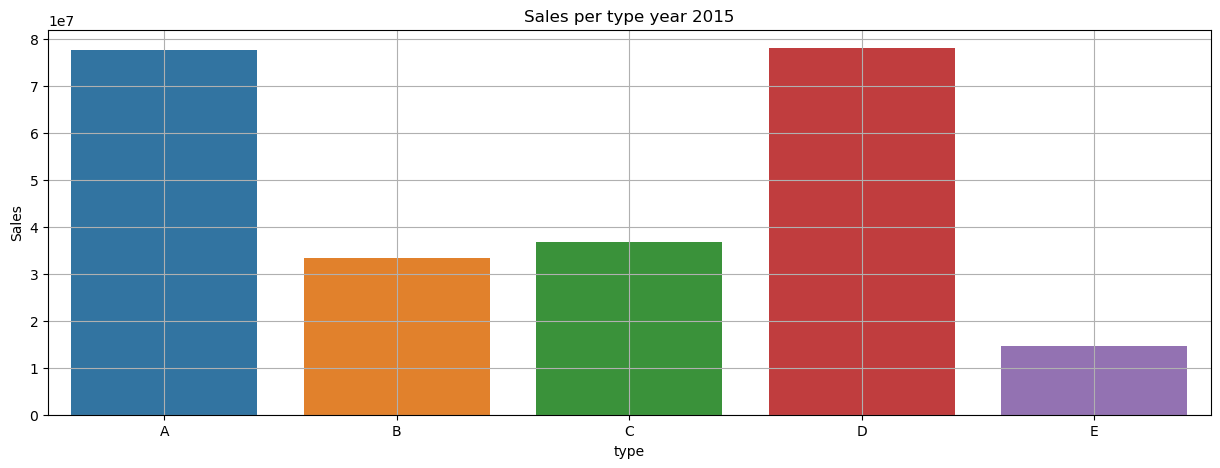

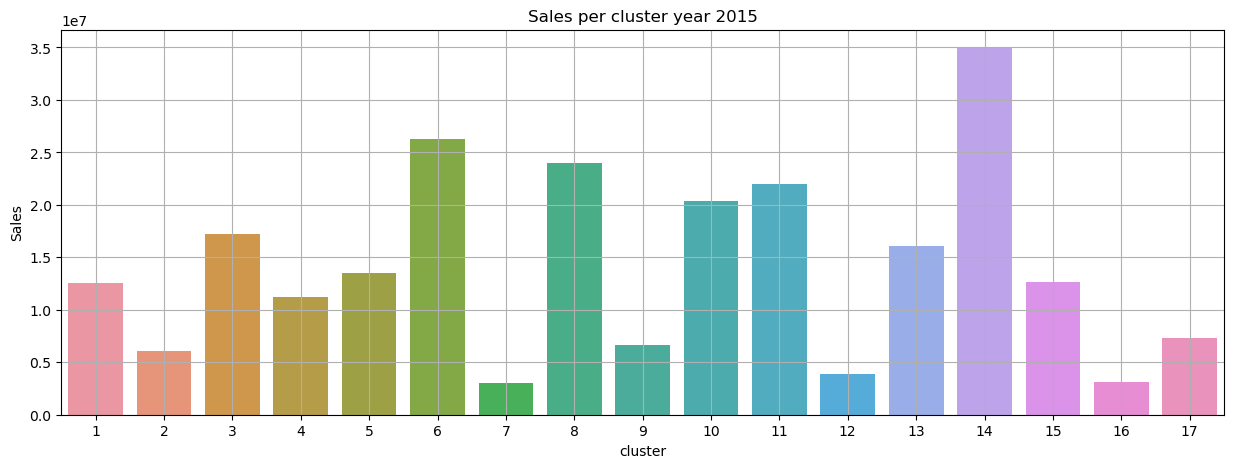

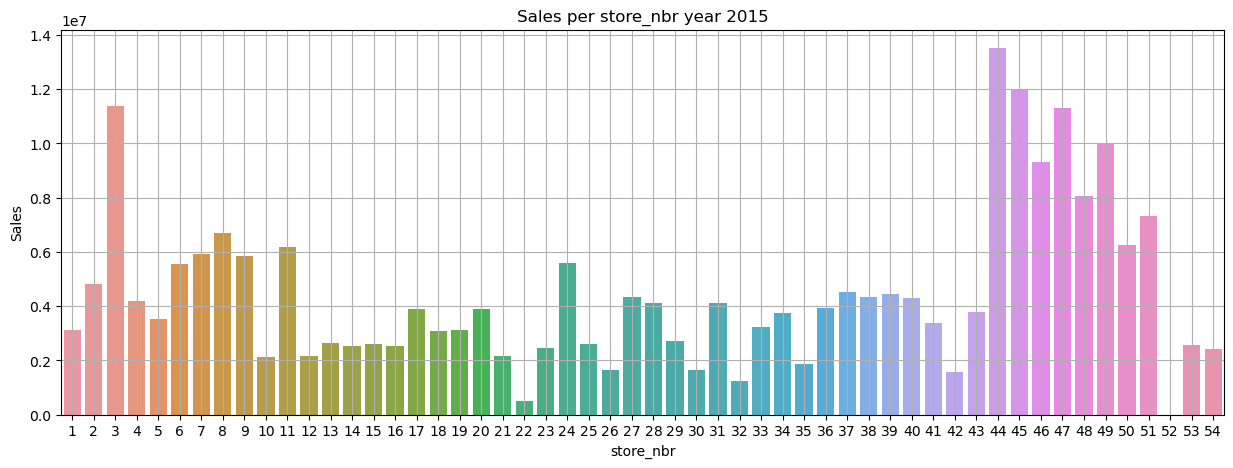

In [16]:
list_name=["family", "onpromotion", "state", "city", "type", "cluster", "store_nbr"]
plt.subplots_adjust(wspace=0.35, hspace=0.35)
for name in list_name:
    plt.figure(figsize=(15,5))
    sales_train_2015_df=store_train_2015_df.groupby([name], as_index=False).agg({"sales":"sum"})
    sns.barplot(x=sales_train_2015_df[name], y="sales", data=sales_train_2015_df)
    plt.title("Sales per {} year {}".format(name,2015))
    plt.ylabel("Sales")
    plt.xlabel(name)
    if name=="state" or name=="city" or name=="family":
        plt.xticks(rotation=70)
    elif name=="onpromotion":
        plt.xticks(range(0, len(sales_train_2015_df[name]), 10))
    else:
        plt.xticks(rotation=0)
    plt.grid("True")
    plt.show()

In [17]:
"""
Let´s analyze the transactions_df
Let´s convert the date column to "datetime" to apply ".dt" and obtain day of the week.
"""
transactions_df["date"]=pd.to_datetime(transactions_df["date"])
transactions_df["Day_of_week"]=transactions_df["date"].dt.day_name()
transactions_df["Month"]=transactions_df["date"].dt.month
transactions_df["Year"]=transactions_df["date"].dt.year.astype(str)
transactions_df

,date,store_nbr,transactions,Day_of_week,Month,Year
0,2013-01-01,25,770,Tuesday,1,2013
1,2013-01-02,1,2111,Wednesday,1,2013
2,2013-01-02,2,2358,Wednesday,1,2013
3,2013-01-02,3,3487,Wednesday,1,2013
4,2013-01-02,4,1922,Wednesday,1,2013
...,...,...,...,...,...,...
83483,2017-08-15,50,2804,Tuesday,8,2017
83484,2017-08-15,51,1573,Tuesday,8,2017
83485,2017-08-15,52,2255,Tuesday,8,2017
83486,2017-08-15,53,932,Tuesday,8,2017


/tmp/ipykernel_32/3719971912.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heat_map=new_subtable.pivot(name, "Year", "transactions")


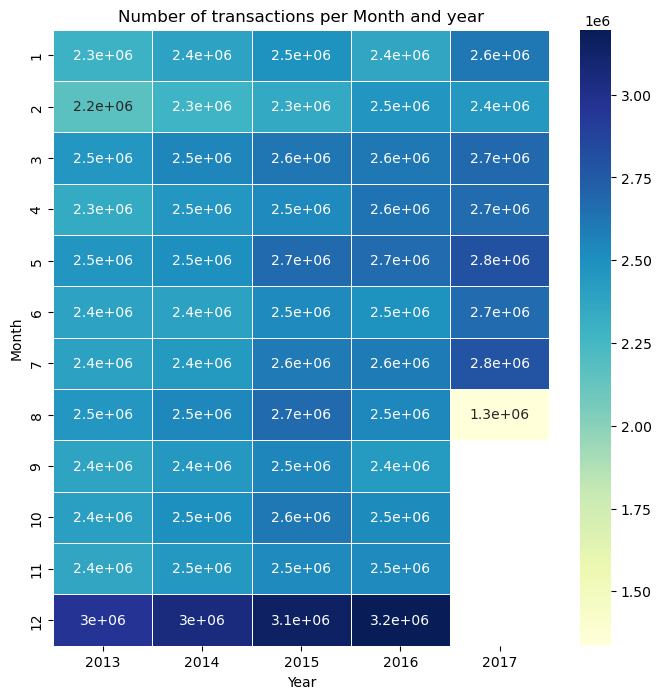

/tmp/ipykernel_32/3719971912.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heat_map=new_subtable.pivot(name, "Year", "transactions")


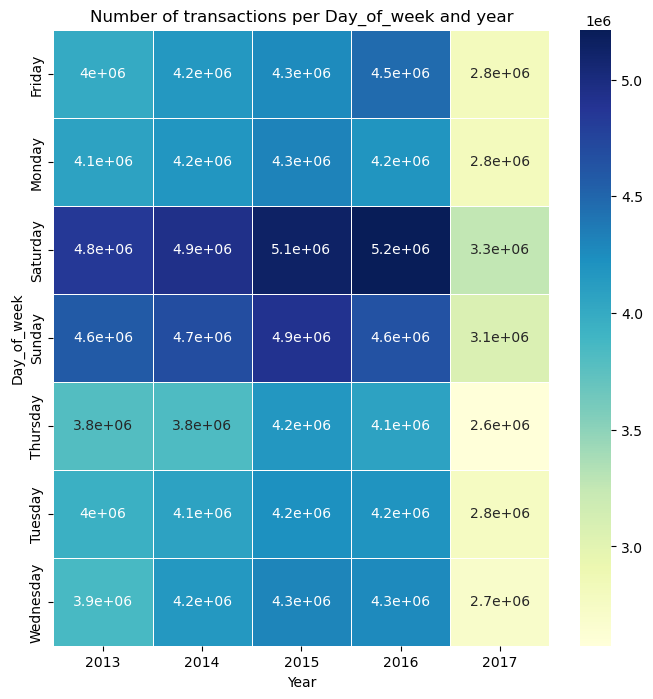

In [18]:
"""
Let´s do the same as before but with two input features to create a heatmap.
"""

list_names=["Month", "Day_of_week"]
for name in list_names:
    plt.figure(figsize=(8,8))
    new_subtable=transactions_df.groupby([name, "Year"], as_index=False).agg({"transactions":"sum"})
    heat_map=new_subtable.pivot(name, "Year", "transactions")
    sns.heatmap(heat_map, annot=True, linecolor="white", linewidths=0.5, cmap="YlGnBu")
    plt.xlabel("Year")
    plt.ylabel(name)
    plt.title("Number of transactions per {} and year".format(name))
    plt.show()

In [19]:
holiday_train_df=train_df.merge(holiday_events_df, how="inner", on="date")
"""
Performs an inner join between two DataFrames "train_df" and "holiday_events_df" based on the common column "date".
how="inner" specifies that an inner join should be performed, meaning only the matching rows between the two DataFrames
will be included in the resulting DataFrame.
"""
holiday_train_df

,id,date,store_nbr,family,sales,onpromotion,Month_x,Year_x,Day,type,locale,locale_name,description,transferred,Month_y,Year_y
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,2013,1,Holiday,National,Ecuador,Primer dia del ano,False,1,2013
1,1,2013-01-01,1,BABY CARE,0.000,0,1,2013,1,Holiday,National,Ecuador,Primer dia del ano,False,1,2013
2,2,2013-01-01,1,BEAUTY,0.000,0,1,2013,1,Holiday,National,Ecuador,Primer dia del ano,False,1,2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,1,2013,1,Holiday,National,Ecuador,Primer dia del ano,False,1,2013
4,4,2013-01-01,1,BOOKS,0.000,0,1,2013,1,Holiday,National,Ecuador,Primer dia del ano,False,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502519,3000883,2017-08-15,9,POULTRY,438.133,0,8,2017,15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,8,2017
502520,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,8,2017,15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,8,2017
502521,3000885,2017-08-15,9,PRODUCE,2419.729,148,8,2017,15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,8,2017
502522,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,8,2017,15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,8,2017


Year 2013:


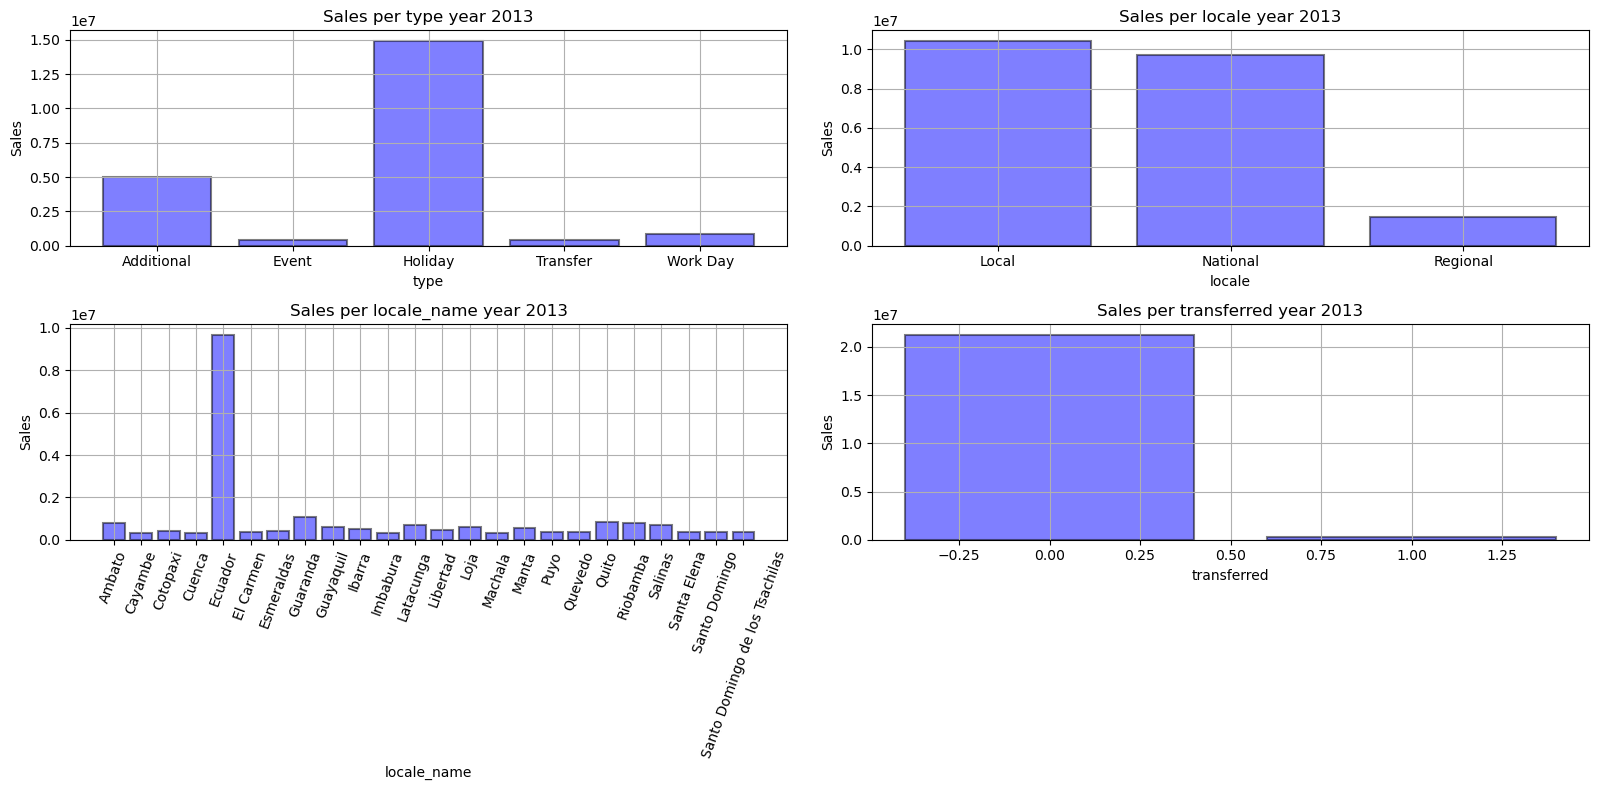







Year 2014:


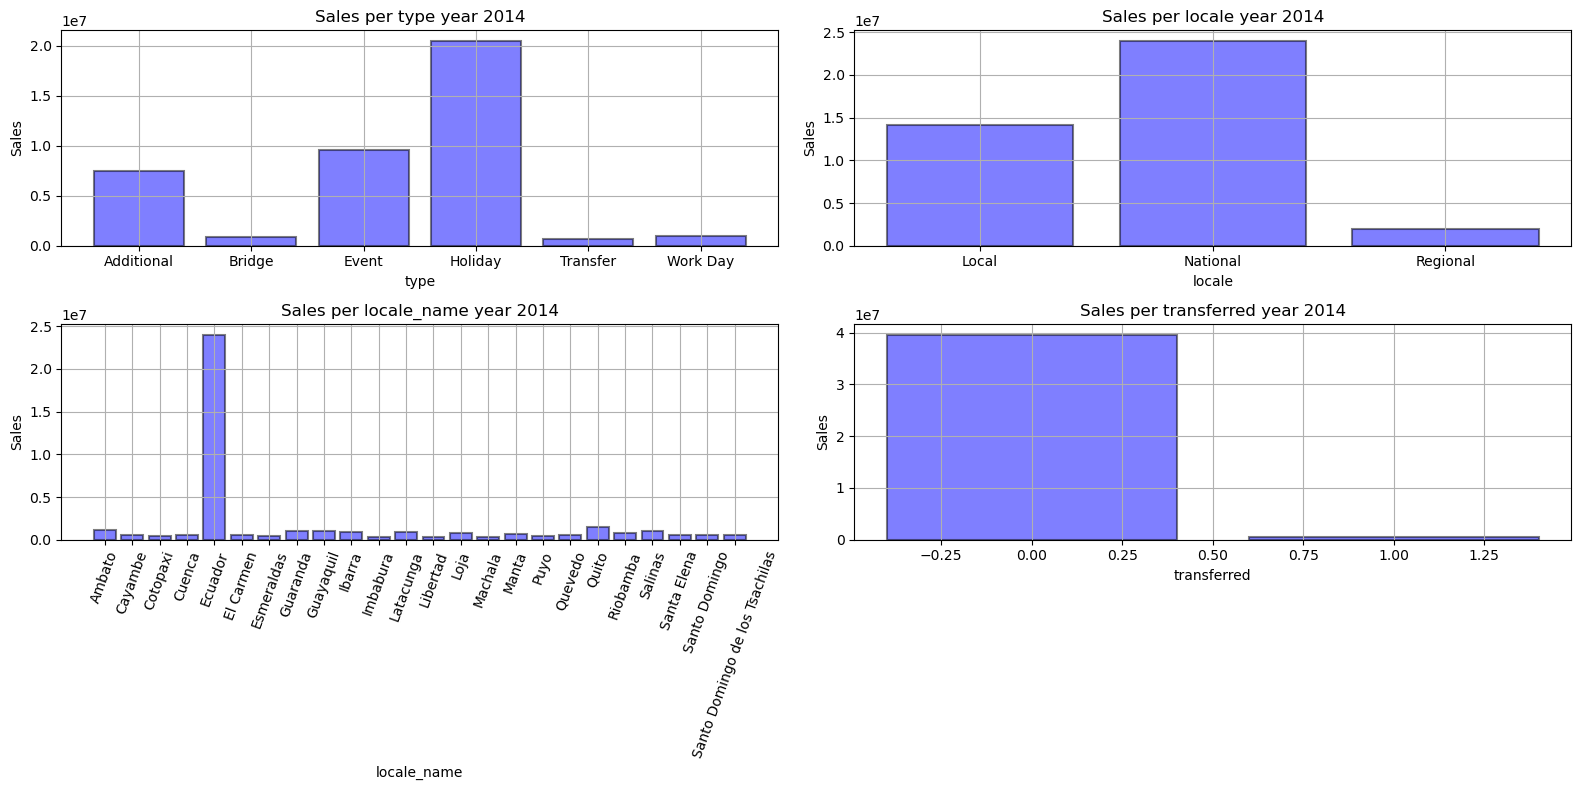







Year 2015:


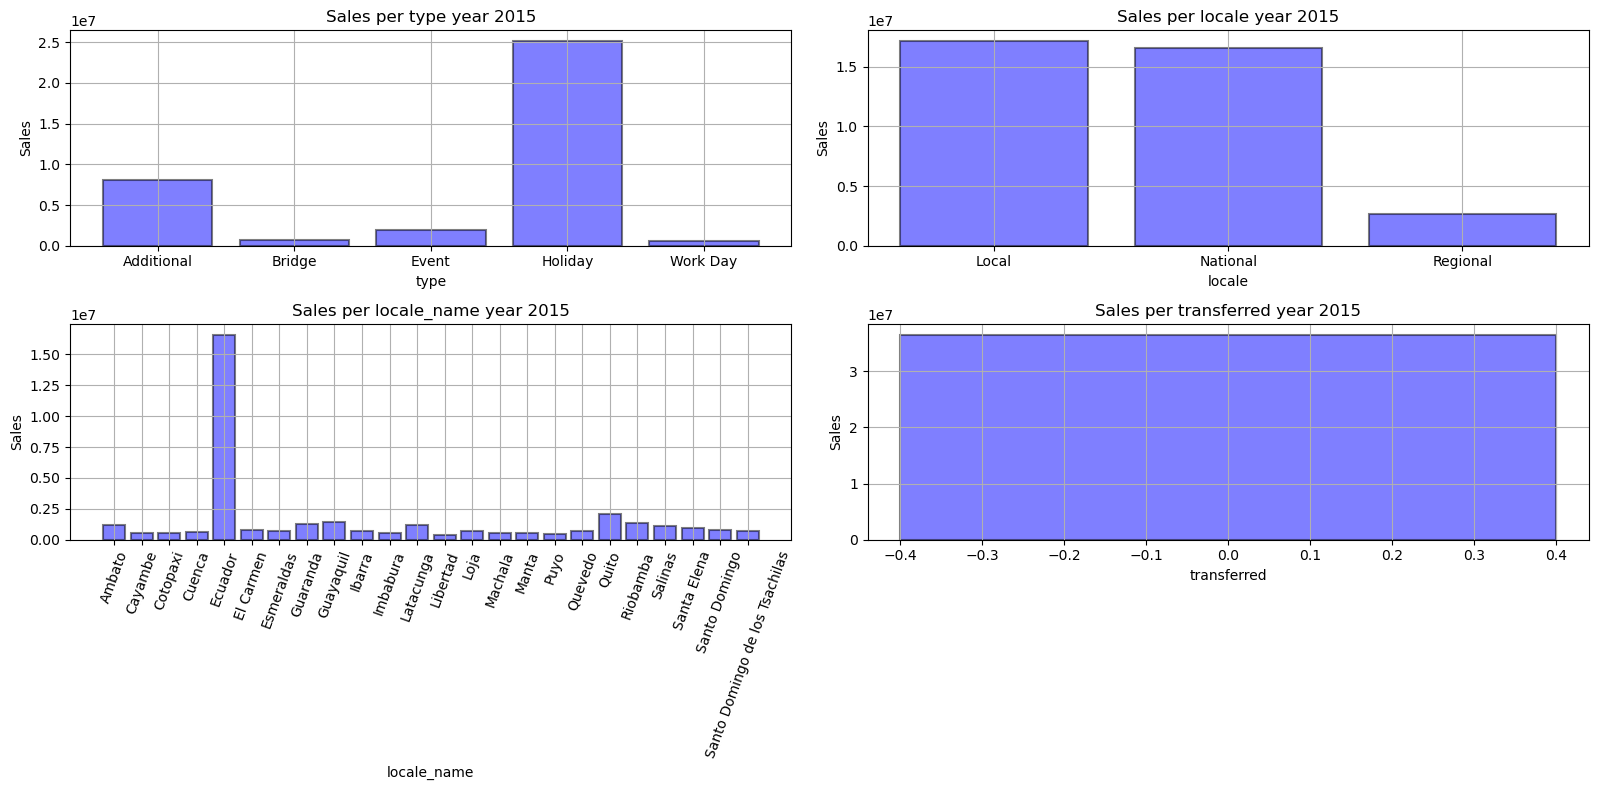







Year 2016:


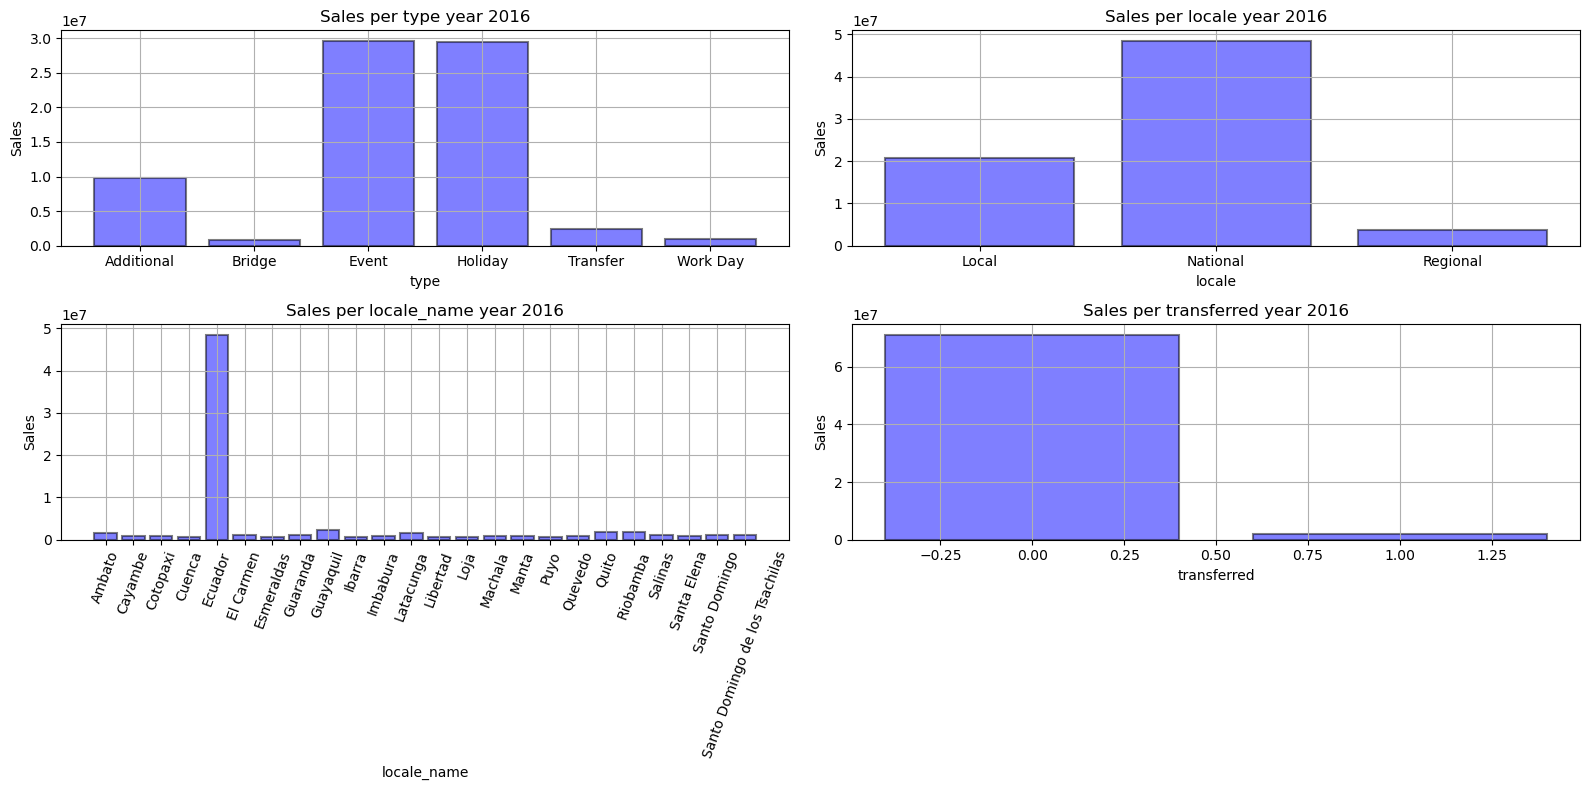







Year 2017:


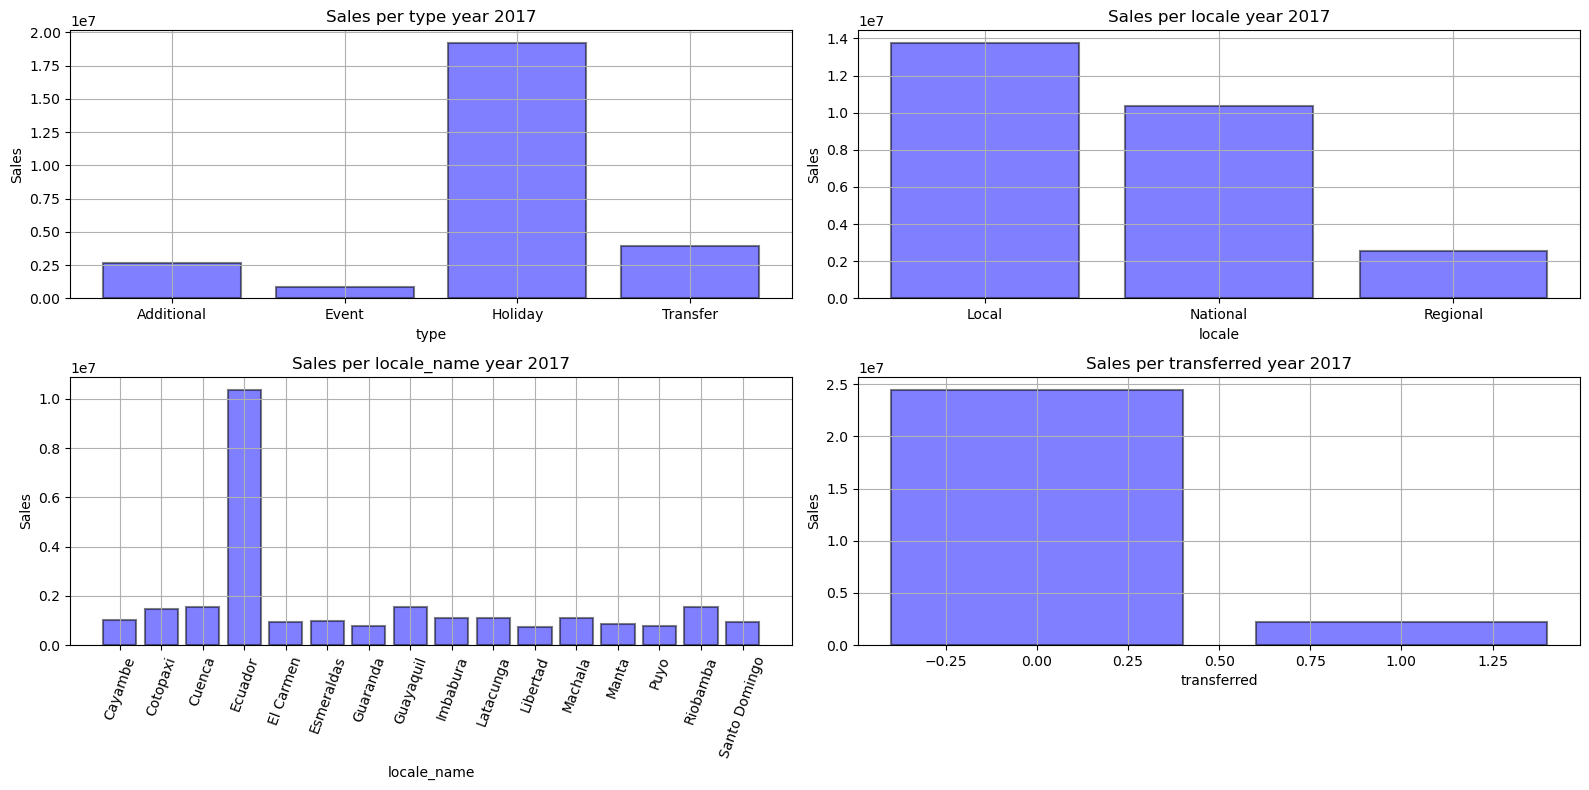

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

list_name=["type", "locale", "locale_name", "transferred"]
list_year=list(holiday_train_df.Year_y.unique())
colors=["blue", "red", "green", "yellow", "purple"]

for year in list_year:
    print("Year {}:".format(year))
    holiday_train_year_df = holiday_train_df[holiday_train_df.Year_y == year]

    nrows=2
    ncols=2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))

    i=0  # rows
    j=0  # columns

    for name in list_name:
        hist_holiday_train_year_df = holiday_train_year_df.groupby([name], as_index=False).agg({"sales": "sum"})
        axs[i,j].bar(hist_holiday_train_year_df[name], hist_holiday_train_year_df["sales"], color="blue", alpha=0.5, edgecolor="black", linewidth=1.5)
        axs[i,j].set_title("Sales per {} year {}".format(name, year))
        axs[i,j].set_ylabel("Sales")
        axs[i,j].set_xlabel(name)
        if name=="locale_name":
            axs[i,j].tick_params(axis="x", rotation=70)
        else:
            axs[i,j].tick_params(axis="x", rotation=0)
        axs[i, j].grid(True)
        j += 1
        if j == ncols:
            i += 1
            j = 0

    plt.tight_layout()
    plt.show()
    print("\n")
    print("\n")
    print("\n")

# **Feature Engineering**

Feature engineering is the process of creating new features or modifying existing features in a dataset to improve the performance and effectiveness of machine learning models. It involves transforming raw data into a format that is more suitable for the model to learn from.

In [21]:
from tqdm import tqdm

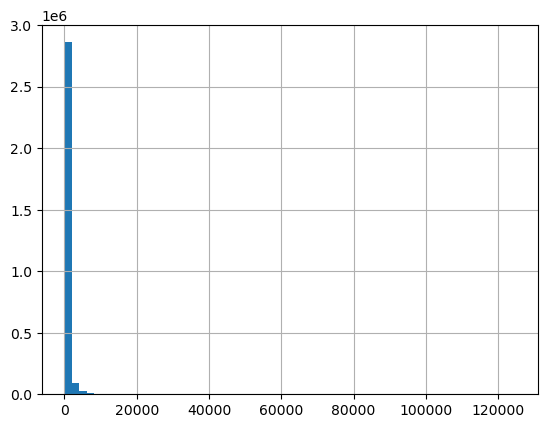

The data is too skewed, let´s apply log transformation to reduce the skewness.


100%|██████████| 3000888/3000888 [00:03<00:00, 757744.43it/s]


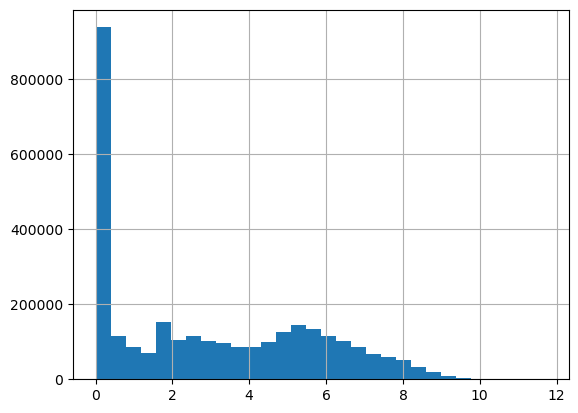

In [22]:

plt.hist(train_df.sales, bins=60)
plt.grid(True)
plt.show()
print("The data is too skewed, let´s apply log transformation to reduce the skewness.")



logsale=[]
for sale in tqdm(train_df.sales):
    sale=np.log1p(float(sale))
    logsale.append(sale)

train_df["logsale"]=logsale

plt.hist(train_df.logsale, bins=30)
plt.grid(True)
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
encoder=LabelEncoder()
train_df["family"]=encoder.fit_transform(train_df["family"].values)
train_df

,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day,logsale
0,0,2013-01-01,1,0,0.000,0,1,2013,1,0.000000
1,1,2013-01-01,1,1,0.000,0,1,2013,1,0.000000
2,2,2013-01-01,1,2,0.000,0,1,2013,1,0.000000
3,3,2013-01-01,1,3,0.000,0,1,2013,1,0.000000
4,4,2013-01-01,1,4,0.000,0,1,2013,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,8,2017,15,6.084802
3000884,3000884,2017-08-15,9,29,154.553,1,8,2017,15,5.046987
3000885,3000885,2017-08-15,9,30,2419.729,148,8,2017,15,7.791824
3000886,3000886,2017-08-15,9,31,121.000,8,8,2017,15,4.804021


In [25]:
label_name=["family", "city", "state", "type"]
for name in label_name:
    store_train_df[name]=encoder.fit_transform(store_train_df[name].values)
store_train_df

,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day,city,state,type,cluster
0,0,2013-01-01,1,0,0.000,0,1,2013,1,18,12,3,13
1,1,2013-01-01,1,1,0.000,0,1,2013,1,18,12,3,13
2,2,2013-01-01,1,2,0.000,0,1,2013,1,18,12,3,13
3,3,2013-01-01,1,3,0.000,0,1,2013,1,18,12,3,13
4,4,2013-01-01,1,4,0.000,0,1,2013,1,18,12,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,8,2017,15,18,12,1,6
3000884,3000884,2017-08-15,9,29,154.553,1,8,2017,15,18,12,1,6
3000885,3000885,2017-08-15,9,30,2419.729,148,8,2017,15,18,12,1,6
3000886,3000886,2017-08-15,9,31,121.000,8,8,2017,15,18,12,1,6


In [26]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [27]:
train_df

,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day,logsale
0,0,2013-01-01,1,0,0.000,0,1,2013,1,0.000000
1,1,2013-01-01,1,1,0.000,0,1,2013,1,0.000000
2,2,2013-01-01,1,2,0.000,0,1,2013,1,0.000000
3,3,2013-01-01,1,3,0.000,0,1,2013,1,0.000000
4,4,2013-01-01,1,4,0.000,0,1,2013,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,8,2017,15,6.084802
3000884,3000884,2017-08-15,9,29,154.553,1,8,2017,15,5.046987
3000885,3000885,2017-08-15,9,30,2419.729,148,8,2017,15,7.791824
3000886,3000886,2017-08-15,9,31,121.000,8,8,2017,15,4.804021


In [28]:
print("Size of the pandas is: ", test_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", test_df.isnull().sum())
print(" ")
print("Information is: \n", test_df.describe())
print(" ")
test_df.head()
#We have to predict sales. We will use a RNN (LSTM)

Size of the pandas is:  (28512, 5)
 
The number of null elements (NaN) is: 
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
 
Information is: 
                  id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000
75%    3.022271e+06     41.000000      6.000000
max    3.029399e+06     54.000000    646.000000
 


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [29]:
print("Size of the pandas is: ", transactions_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", transactions_df.isnull().sum())
print(" ")
print("Information is: \n", transactions_df.describe())
print(" ")
transactions_df.head()

Size of the pandas is:  (83488, 6)
 
The number of null elements (NaN) is: 
 date            0
store_nbr       0
transactions    0
Day_of_week     0
Month           0
Year            0
dtype: int64
 
Information is: 
           store_nbr  transactions         Month
count  83488.000000  83488.000000  83488.000000
mean      26.939237   1694.602158      6.240801
std       15.608204    963.286644      3.374489
min        1.000000      5.000000      1.000000
25%       13.000000   1046.000000      3.000000
50%       27.000000   1393.000000      6.000000
75%       40.000000   2079.000000      9.000000
max       54.000000   8359.000000     12.000000
 


,date,store_nbr,transactions,Day_of_week,Month,Year
0,2013-01-01,25,770,Tuesday,1,2013
1,2013-01-02,1,2111,Wednesday,1,2013
2,2013-01-02,2,2358,Wednesday,1,2013
3,2013-01-02,3,3487,Wednesday,1,2013
4,2013-01-02,4,1922,Wednesday,1,2013


**Building the RNN (test, not final model)**

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [33]:
#Build the RNN architecture
model=Sequential()
model.add(SimpleRNN(units=32, input_shape(10,1)))
model.add(Dense(units=1))

#Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

#Train the model
model.fit(X,y, epochs=10, batch_size=32)

SyntaxError: positional argument follows keyword argument (3777579158.py, line 3)